In [1]:
import sys
import os

# Add the parent directory of "tests" to sys.path
sys.path.append(os.path.abspath("/Users/workspace/Software/Layered_Tank_Simulation/CherenkovSim/"))

In [2]:
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.units as u

from cherenkov_sim.constants import ALPHA, R_TANK, H_TANK, TOP_TANK, ELECTRON_MASS


In [3]:
# Extract starting position randomly from a circle corresponding to the top of the tank
N_event = 1000 # Choose number of particles 

# Gen. surface radius 
R_gen = 180 * u.cm 
 
def rnd_tank_start(R_gen, N_event): 
    r = R_gen * np.sqrt(np.random.uniform(0,1,size=N_event))
    alpha = np.random.uniform(0,2*np.pi, size=N_event) 
    z_value = 140 
    x0 = r * np.cos(alpha)   
    y0 = r * np.sin(alpha)  
    z0 = np.full(N_event,z_value) * u.cm
    return x0, y0, z0   


def rnd_direction(N_event):
    phi = np.random.uniform(0,2*np.pi, size=N_event)

    theta_0 = 0 * u.deg 
    theta_1 = 30 * u.deg 
    cos_theta_squared = np.random.uniform(np.cos(theta_1.to(u.rad))**2,np.cos(theta_0.to(u.rad))**2, size=N_event)
    cos_theta = np.sqrt(cos_theta_squared)
    theta = np.arccos(cos_theta) 
    return theta * u.rad, phi * u.rad

In [4]:
# Track muons inside the tank, considering energy loss and Cherenkov produciton 

muon_theta, muon_phi = rnd_direction(N_event)
x0,y0,z0 = rnd_tank_start(R_gen, N_event)  

initial_position = np.array([x0[0].value,y0[0].value,z0[0].value]) * u.cm
theta = muon_theta[0]
phi = muon_phi[0]

In [5]:
def _compute_direction(zenith, azimuth):
    """
    Converts zenith (θ) and azimuth (φ) angles into a unit direction vector.

    :param zenith: Angle from vertical (0° = downward, 90° = horizontal).
    :param azimuth: Angle from x-axis (0° = x, 90° = y, 180° = -x, 270° = -y).
    :return: A NumPy array representing the direction vector.
    """
    theta = zenith.to(u.rad).value  # Convert degrees to radians
    phi = azimuth.to(u.rad).value  # Convert degrees to radians
    # Convert spherical coordinates to Cartesian unit vector
    direction = np.array([
        np.sin(theta) * np.cos(phi),  # x-component
        np.sin(theta) * np.sin(phi),  # y-component
        np.cos(theta)                # z-component
    ])
    return direction / np.linalg.norm(direction)  # Ensure it's a unit vector]

In [6]:
dir_photon =np.asarray(_compute_direction(theta,phi))
print(dir_photon)

[0.24152861 0.42267717 0.87350326]


In [7]:
nx = np.asarray([1,0,0])

In [8]:
# Compute versor perpendicular to photon direction 
e1 = np.cross(nx, dir_photon) / np.linalg.norm(np.cross(nx, dir_photon) ) 
print(e1)


[ 0.         -0.90015347  0.43557287]


In [9]:
e2 = np.cross(dir_photon, e1)
print(e2)

[ 0.9703937  -0.10520331 -0.21741282]


In [10]:
# Cross check that they are perpendicular 
print(np.dot(e1,dir_photon))
print(np.dot(e2,dir_photon))
print(np.dot(e1,e2))


-2.9491150474963995e-18
1.475481442744645e-17
-8.684704941311713e-18


In [11]:
# Compute opening angle of electron positron pair with respect to the photon 
theta_pp = 0.511 / 1 * u.rad
print('Opening angle is ',theta_pp.to(u.deg))

cos_pp = np.cos(theta_pp)
sin_pp = np.sin(theta_pp)

Opening angle is  29.278143331185067 deg


In [12]:
# Compute azimuthal angle on the plane perpendicular to the direction of the photon 
rng = np.random.default_rng()  
phi_pp = rng.uniform(0, 1, size=1) * 2 * np.pi

In [13]:
n_e_minus = e1 * np.cos(phi_pp) * sin_pp + e2 * np.sin(phi_pp) * sin_pp + dir_photon * cos_pp
n_e_plus = e1 * np.cos(phi_pp + np.pi) * sin_pp + e2 * np.sin(phi_pp + np.pi) * sin_pp + dir_photon * cos_pp

In [14]:
# Check that they are normalized
print(np.linalg.norm(n_e_minus))
print(np.linalg.norm(n_e_plus))

1.0
1.0


In [15]:
print(dir_photon)
print(n_e_minus)
print(n_e_plus)



[0.24152861 0.42267717 0.87350326]
[-0.16189417  0.13639592  0.9773364 ]
[0.58324368 0.60096938 0.54650033]


In [16]:
vectors = np.array([dir_photon, n_e_minus.value, n_e_plus.value])
vectors[:,0:2]

array([[ 0.24152861,  0.42267717],
       [-0.16189417,  0.13639592],
       [ 0.58324368,  0.60096938]])

Text(0, 0.5, 'z')

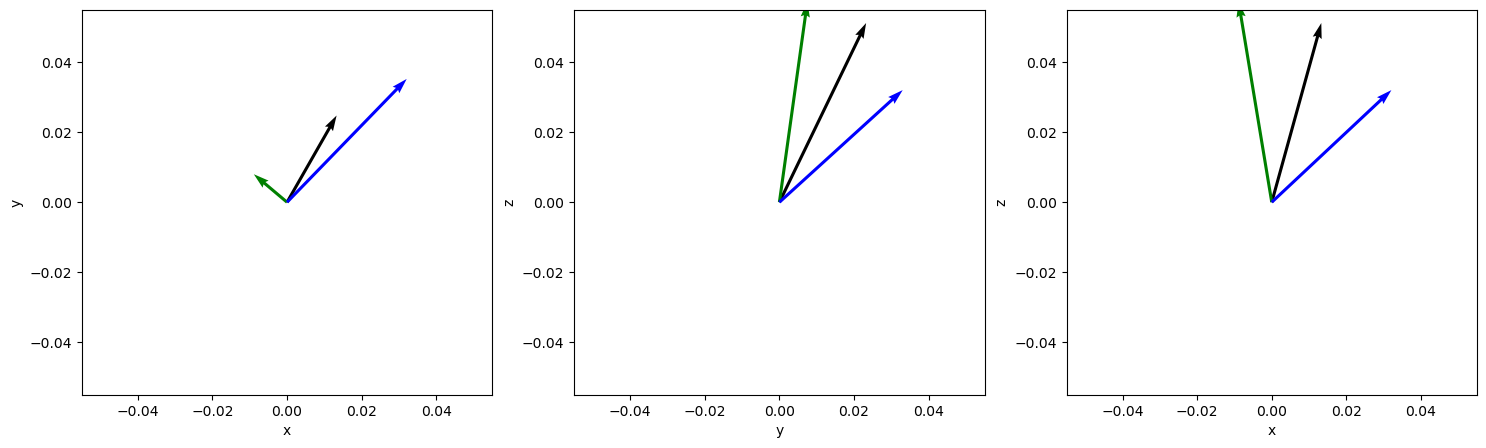

In [17]:
plt.subplots(1,3,figsize=(18
                        ,5))
plt.subplot(1,3,1)
plt.quiver(0,0,*dir_photon[0:2], color='black',scale=2)
plt.quiver(0,0,*n_e_minus[0:2].value,  color='green', scale=2)
plt.quiver(0,0,*n_e_plus[0:2].value, color='blue', scale=2)
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1,3,2)
plt.quiver(0,0,*dir_photon[1:], color='black',scale=2)
plt.quiver(0,0,*n_e_minus[1:].value,color='green', scale=2)
plt.quiver(0,0,*n_e_plus[1:].value, color='blue',scale=2)
plt.xlabel('y')
plt.ylabel('z')

plt.subplot(1,3,3)
plt.quiver(0,0,*[dir_photon[0], dir_photon[-1]], color='black',scale=2)
plt.quiver(0,0,*[n_e_minus[0].value, n_e_minus[-1].value],color='green', scale=2)
plt.quiver(0,0,*[n_e_plus[0].value, n_e_plus[-1].value], color='blue', scale=2)
plt.xlabel('x')
plt.ylabel('z')


In [18]:
theta_electron = np.arccos(n_e_minus[2]).value
phi_electron = np.arctan2(n_e_minus[1],n_e_minus[0]).value

theta_positron = np.arccos(n_e_plus[2]).value
phi_positron = np.arctan2(n_e_plus[1],n_e_plus[0]).value

print(theta_electron, phi_electron)
print(theta_positron, phi_positron)


0.213306030002586 2.441468556743737
0.9926167281454014 0.8003653874996141


In [19]:
n_e_minus_check = [np.sin(theta_electron) * np.cos(phi_electron),
                   np.sin(theta_electron) * np.sin(phi_electron),
                   np.cos(theta_electron)
]

n_e_plus_check = [np.sin(theta_positron) * np.cos(phi_positron),
                   np.sin(theta_positron) * np.sin(phi_positron),
                   np.cos(theta_positron)
]

Text(0, 0.5, 'z')

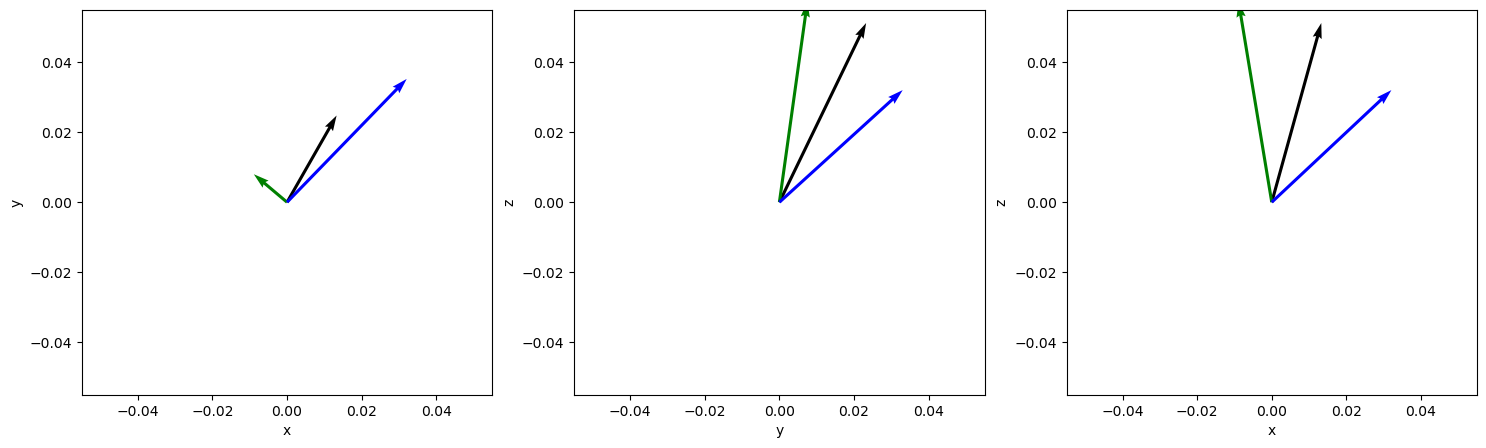

In [20]:
plt.subplots(1,3,figsize=(18
                        ,5))
plt.subplot(1,3,1)
plt.quiver(0,0,*dir_photon[0:2], color='black',scale=2)
plt.quiver(0,0,*n_e_minus_check[0:2], color='green',scale=2)
plt.quiver(0,0,*n_e_plus_check[0:2], color='blue', scale=2)
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1,3,2)
plt.quiver(0,0,*dir_photon[1:], color='black',scale=2)
plt.quiver(0,0,*n_e_minus_check[1:],color='green', scale=2)
plt.quiver(0,0,*n_e_plus_check[1:], color='blue',scale=2)
plt.xlabel('y')
plt.ylabel('z')

plt.subplot(1,3,3)
plt.quiver(0,0,*[dir_photon[0], dir_photon[-1]], color='black',scale=2)
plt.quiver(0,0,*[n_e_minus_check[0], n_e_minus_check[-1]],color='green', scale=2)
plt.quiver(0,0,*[n_e_plus_check[0], n_e_plus_check[-1]],color='blue', scale=2)
plt.xlabel('x')
plt.ylabel('z')

(0.0, 1.1)

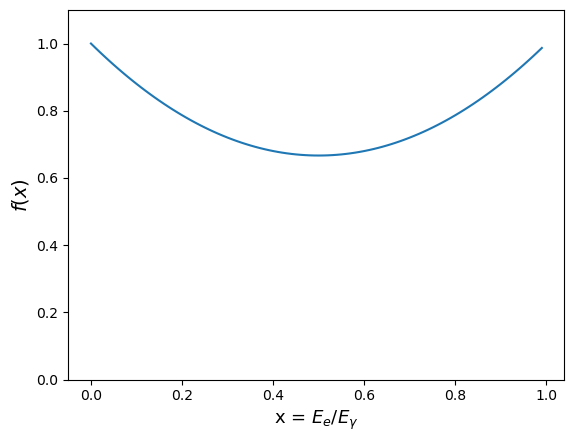

In [21]:
# Functional for of differential cross section 
xvalues = np.arange(0,1,0.01)

def dsigma_dx(x):
    return (1 - 4./3 * x * (1-x))

plt.plot(xvalues,dsigma_dx(xvalues))

plt.xlabel(r'x = $E_{e}/E_{\gamma}$',size=13)
plt.ylabel(r'$f(x)$',size=14)
plt.ylim(0,1.1)

In [22]:
# Extract electron energy fraction following this distribution 

rng = np.random.default_rng()  

def extract_x_fraction():
    while True:
        x_value = rng.uniform(0, 1, size=1) 
        y_value = rng.uniform(0, 1, size=1) 
        if y_value < dsigma_dx(x_value):
            return x_value[0]
        
x_frac = []


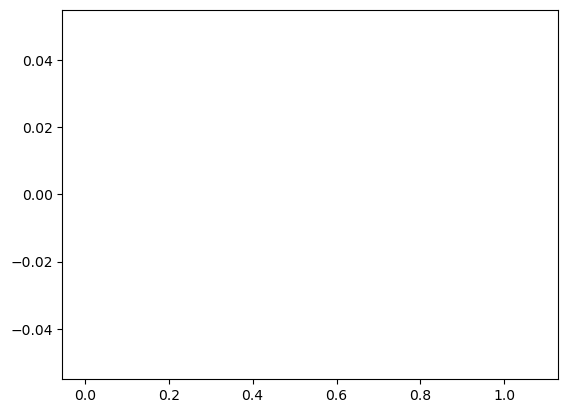

In [24]:
hist = plt.hist(x_frac, bins=np.arange(0,1.1,0.025))

Text(0, 0.5, 'f $(\\cos\\theta)$ Compton')

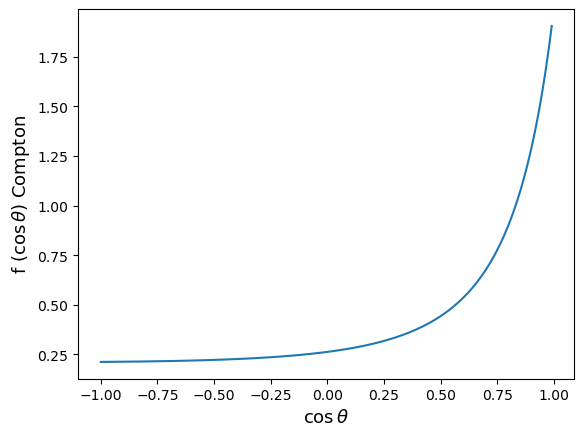

In [25]:
# Now for the Compton scattering 

def dsigma_dcos_compton(E, cos_theta):
    # Ignore normalization constant, just care about functional shape
    theta_term = 1 + ( E.to(u.keV) * (1 - cos_theta) /ELECTRON_MASS.to(u.keV)  )

    return (1/theta_term**2) * (theta_term + 1. / theta_term - (1 - cos_theta**2) )

cos_values = np.arange(-1,1,0.01)

plt.plot(cos_values, dsigma_dcos_compton(1*u.MeV,cos_values))
plt.xlabel(r'$\cos\theta$',size=13)
plt.ylabel(r'f $(\cos\theta)$ Compton',size=13)

In [26]:
def extract_costheta(E):
    while True:
        x_value = rng.uniform(-1, 1, size=1) 
        y_value = rng.uniform(0, dsigma_dcos_compton(E,1), size=1) 
        #print('x value :',x_value)
        #print('f(x) value :',dsigma_dcos_compton(E,x_value))
        #print('y value :',y_value)
        if y_value < dsigma_dcos_compton(E,x_value):
            return x_value[0]
        

In [31]:
cos_theta = []
for i in range(1000):
    cos_theta.append(extract_costheta(1 * u.GeV))

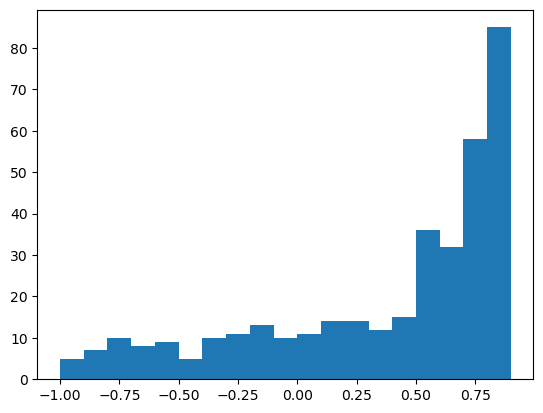

In [32]:
hist = plt.hist(cos_theta,bins=np.arange(-1,1,0.1))
